In [104]:
from dolfin import *
import numpy as np
import sys as sys
sys.path.append('../src/3D_to_1D/')
sys.path.append('../src/3D_to_1D/scripts/')
import pvs1D_utils as utils
import imp as imp
imp.reload(utils)

import pvs1D_utils as utils
from post_process import *

In [105]:
# Read 1d mesh
mesh1D = Mesh()
case_path = '../src/C0092/'
results_path = '../results/results_B1/'
case_prefix = 'C0092_clip1_mesh1_0.95_ratio'
mesh1D_file = case_path + case_prefix + "_centerline_mesh.xdmf"
with XDMFFile(MPI.comm_world, mesh1D_file) as xdmf:
    xdmf.read(mesh1D)

# Read 1d coarse mesh
# (generated by make_coarse_1D_mesh.py)
mesh1D_c = Mesh()

mesh1D_file = results_path + "avg/XDMF/mesh1D_c_0.xdmf"
with XDMFFile(MPI.comm_world, mesh1D_file) as xdmf:
    xdmf.read(mesh1D_c)
    
# Shrink the geometry with a given constant
L_PVS = 44e-3 # [mm]
coord_factor = 2.0/L_PVS
    
mesh1D.coordinates()[:]/=coord_factor
# mesh1D_c does not have to be shrunk, as it was generated from mesh1D

# Read in radius
radius_hfile  = HDF5File(MPI.comm_world, case_path + case_prefix + "_HDF5/centerline_radius.h5", "r")
radius_a = Function(FunctionSpace(mesh1D, 'CG', 1))
radius_hfile.read(radius_a, "/function/vector_0")

radius_a.vector()[:]/=coord_factor #shrink

radius_a.vector()[:]*=0.5 # why is this needed?

radius_pv = project(2.95*radius_a, FunctionSpace(mesh1D, 'CG', 1))

mesh3D = Mesh()
mesh3D_file = case_path + case_prefix + "_PVS.xdmf"
with XDMFFile(MPI.comm_world, mesh3D_file) as xdmf:
    xdmf.read(mesh3D)
    
mesh3D.coordinates()[:]/=coord_factor

A_pv = project(3.14159*(radius_pv**2.0-radius_a**2.0), FunctionSpace(mesh1D, 'CG', 1))


In [111]:
## Read in 1d solutions, 3d solutions and 3d averages ##

file_u = HDF5File(MPI.comm_world, results_path + '3D/HDF5/u.h5','r')
file_p = HDF5File(MPI.comm_world, results_path + '3D/HDF5/p.h5','r')

file_u_avg = HDF5File(MPI.comm_world, results_path + 'avg/HDF5/q_avg0.h5','r')
file_p_avg = HDF5File(MPI.comm_world, results_path + 'avg/HDF5/p_avg.h5','r')

file_p1D = HDF5File(MPI.comm_world, results_path + '1D/HDF5/p1D.h5','r')
file_q1D = HDF5File(MPI.comm_world, results_path + '1D/HDF5/q1D0.h5','r')

V1_c = FunctionSpace(mesh1D_c, 'CG', 1)

attr = file_u.attributes("/function")
nsteps = attr['count'] 

tang_comps = read_tangent(case_path, mesh1D, [])

V1_c = FunctionSpace(mesh1D_c, 'CG', 1)

u = Function(VectorFunctionSpace(mesh3D, "CG", 2))
file_u.read(u, name = "/function/vector_2")

p = Function(FunctionSpace(mesh3D, "CG", 1))
file_p.read(p, "/function/vector_2")

p_avg = Function(FunctionSpace(mesh1D, "CG", 1))
file_p_avg.read(p_avg, "/function/vector_0")

u_avg = Function(FunctionSpace(mesh1D_c, "CG", 1))
file_u_avg.read(u_avg, "/function/vector_0")

# Read in 1D solutions at this time step
q1D = Function(FunctionSpace(mesh1D, "CG", 2))
file_q1D.read(q1D, "/function/vector_1")

p1D = Function(FunctionSpace(mesh1D, "CG", 1))
file_p1D.read(p1D, "/function/vector_1")

In [112]:
# Check points we can plot

print('Point 1')
x0 = mesh1D_c.coordinates()[60]
print(f'x0: ({x0[0]:1.3f}, {x0[1]:1.3f}, {x0[2]:1.3f})')
print(f'tau: ({tang_comps[0](x0):1.3f}, {tang_comps[1](x0):1.3f}, {tang_comps[2](x0):1.3f})')

print(f'Radius 1: {radius_a(x0):1.3f}')
print(f'Radius 2: {radius_pv(x0):1.3f}')
print('\nPoint 2')

x0 = mesh1D_c.coordinates()[len(mesh1D_c.coordinates())-60]
print(f'x0: ({x0[0]:1.3f}, {x0[1]:1.3f}, {x0[2]:1.3f})')
print(f'tau: ({tang_comps[0](x0):1.3f}, {tang_comps[1](x0):1.3f}, {tang_comps[2](x0):1.3f})')

print(f'Radius 1: {radius_a(x0):1.3f}')
print(f'Radius 2: {radius_pv(x0):1.3f}')

Point 1
x0: (0.787, 0.206, 1.151)
tau: (-0.051, -0.997, 0.060)
Radius 1: 0.022
Radius 2: 0.065

Point 2
x0: (0.382, 0.499, 0.771)
tau: (0.373, -0.853, 0.366)
Radius 1: 0.020
Radius 2: 0.058


In [120]:
p_error = errornorm(p1D,p_avg)/norm(p_avg)
p_error

print('%1.2e'%mesh3D.hmin())
print('%1.2e'%mesh1D.hmin())


9.42e-03
2.84e-04


In [114]:
q1D_c = interpolate(q1D, u_avg.function_space())
u_error = errornorm(q1D_c,u_avg)/norm(u_avg)
u_error

0.12599278637213365

In [121]:
x0 = mesh1D_c.coordinates()[100]

print('%1.2e'%u_avg(x0))
print('%1.2e'%q1D_c(x0))

4.97e-04
4.28e-04


In [116]:
avg_u = np.average(u_avg.vector().get_local())
diff = np.max(avg_u - u_avg.vector().get_local())
minn = np.min(u_avg.vector().get_local())
maxx = np.max(u_avg.vector().get_local())

print('%1.2e pm %1.3e'%(avg_u, diff) + 'with max %1.2e and min %1.2e'%(maxx, minn))

4.84e-04 pm 1.341e-04with max 5.31e-04 and min 3.50e-04


In [17]:
# Compute relative error

q1Dc = interpolate(q1D, u_avg.function_space())
Apv_c = interpolate(A_pv, u_avg.function_space())

# There's a sign difference between q1D and u_avg
# therefore we add them together

error_q = project(q1Dc+u_avg*A_pv, q1Dc.function_space())
print(f'Relative error: {norm(error_q)/norm(q1Dc)*100:2.2f}%')

Relative error: 101.58%


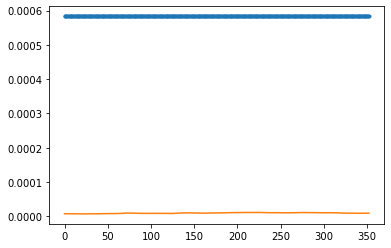

In [29]:
plt.plot(q1Dc.vector().get_local(), '.')
A_pvc = interpolate(A_pv, V1_c)
plt.plot(u_avg.vector().get_local()*A_pvc.vector().get_local())